<a href="https://colab.research.google.com/github/alexwonton/forex-data-fft/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
%pip install yfinance

In [113]:
# For data manipulation
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# Set the ticker as 'EURUSD=X'
forex_data_hour = yf.download('GC=F', period='1mo', interval='1H')

# Set the index to a datetime object
forex_data_hour.index = pd.to_datetime(forex_data_hour.index)

# Display the last five rows
forex_data_hour.tail()

df = pd.DataFrame(forex_data_hour)
prices = df['Close'].values

[*********************100%***********************]  1 of 1 completed


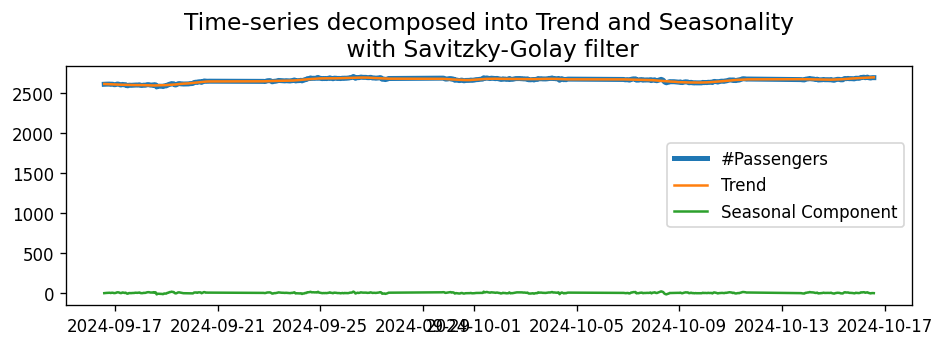

In [138]:
from scipy.signal import savgol_filter

# Create time indices based on the length of prices (0 to len(prices) - 1)
time_indices = np.arange(len(prices))

yvalues = df['Close'].values
yvalues_trend = savgol_filter(yvalues,25,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index.values, yvalues, label='#Passengers',linewidth=3)
ax.plot(df.index.values, yvalues_trend, label='Trend')
ax.plot(df.index.values, yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()

prices = yvalues_detrended

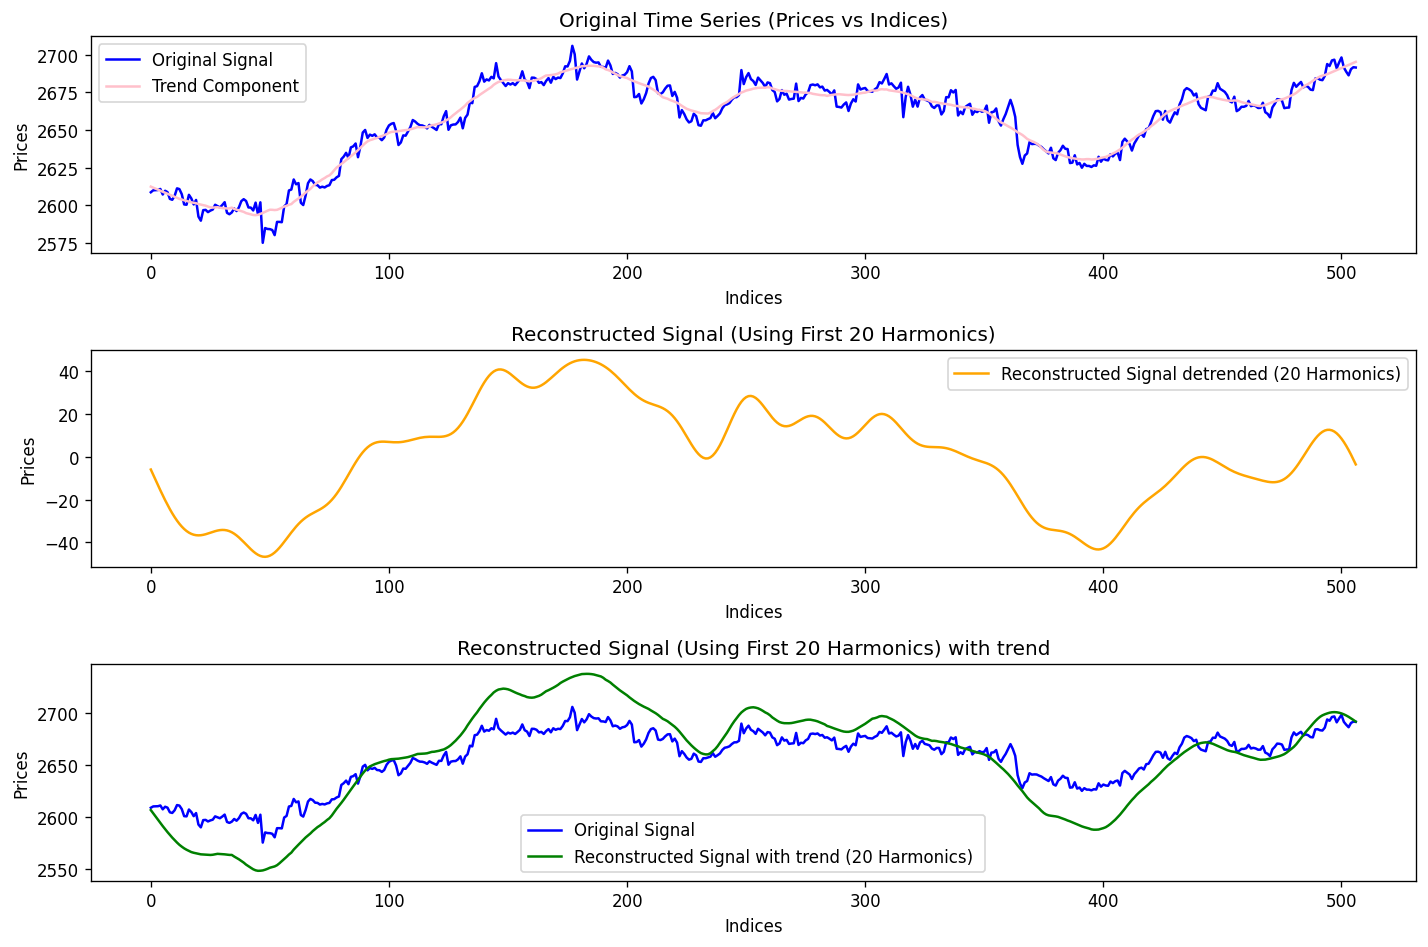

In [139]:

# Perform FFT
N = len(prices)
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain only the first few harmonics, including the DC component
num_harmonics = 20  # Adjust this number as needed
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(N)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones(N)
    else:
        # Harmonic components
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * time_indices + phase)

# Plot original time series data
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(time_indices, yvalues_trend, label='Trend Component', color='pink')
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal using only a few harmonics
plt.subplot(3, 1, 2)
plt.plot(time_indices, reconstructed_signal, label=f"Reconstructed Signal detrended ({num_harmonics} Harmonics)", color='orange')
plt.title(f"Reconstructed Signal (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

reconstructed_signal_with_trend = yvalues_trend + reconstructed_signal
# Plot the reconstructed signal using only a few harmonics
plt.subplot(3, 1, 3)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(time_indices, reconstructed_signal_with_trend, label=f"Reconstructed Signal with trend ({num_harmonics} Harmonics) ", color='green')
plt.title(f"Reconstructed Signal (Using First {num_harmonics} Harmonics) with trend")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()

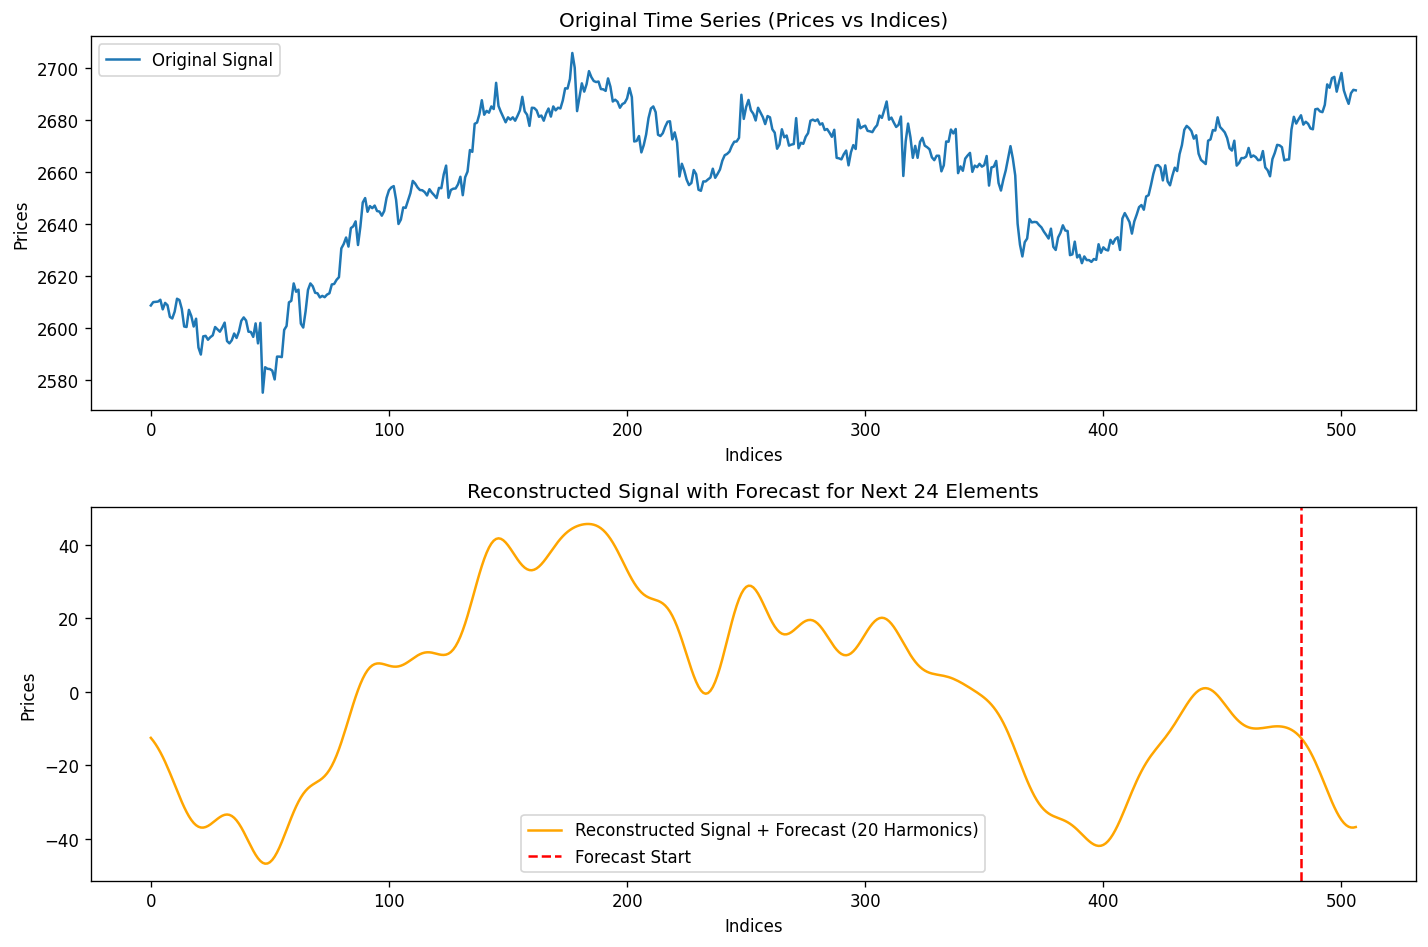

In [118]:
# Define how many elements to exclude (last 24)
exclude_elements = 24
prices_for_fft = prices[:-exclude_elements]  # Remove the last 24 elements for FFT

# Perform FFT on the data excluding the last 24 elements
N = len(prices_for_fft)
fft_result = np.fft.fft(prices_for_fft)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain the first few harmonics, including the DC component
num_harmonics = 20
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Create extended indices including future points
total_length = len(prices)
extended_indices = np.arange(total_length)

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(total_length)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:  # DC component
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
    else:
        # Other harmonics
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)

# Plot original time series data and the forecast
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(prices)), df['Close'].values, label="Original Signal")
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal with forecast
plt.subplot(2, 1, 2)
plt.plot(extended_indices, reconstructed_signal, label=f"Reconstructed Signal + Forecast ({num_harmonics} Harmonics)", color='orange')
plt.axvline(x=len(prices) - exclude_elements, color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Signal with Forecast for Next {exclude_elements} Elements")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()

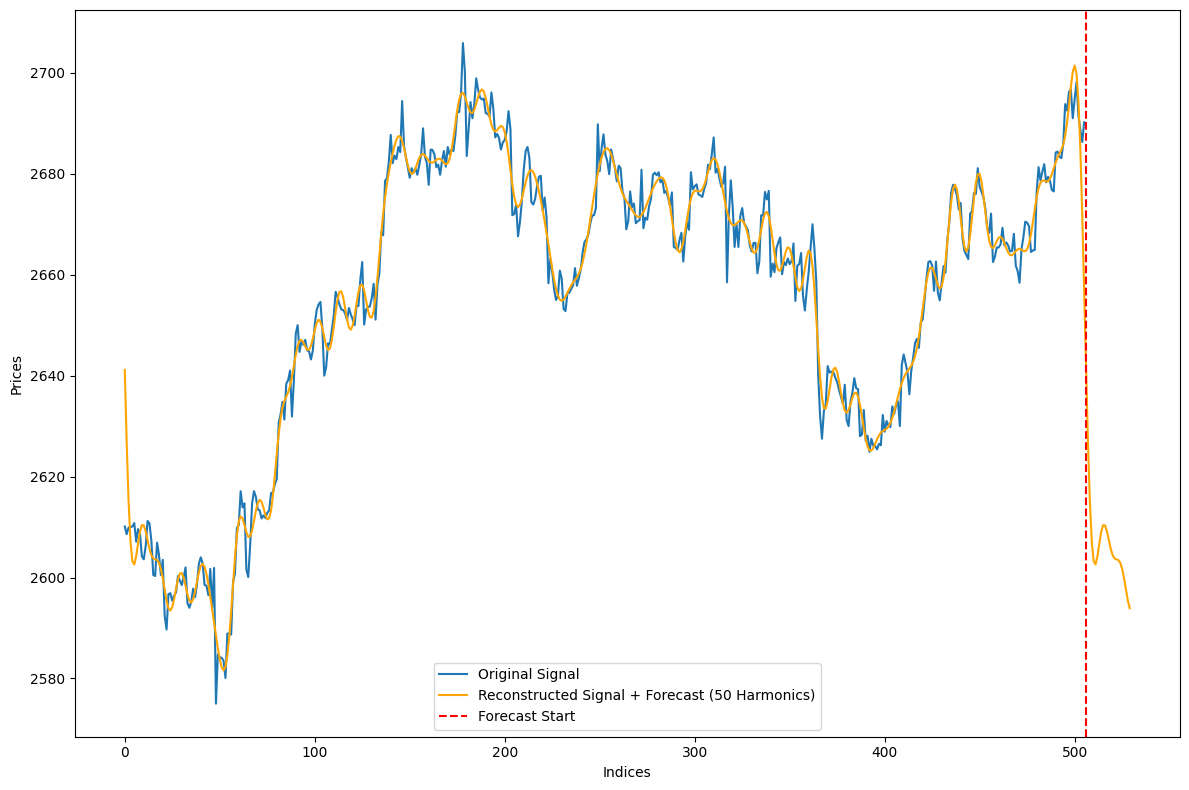

In [25]:
# Define how many elements to exclude (last 48)
forecast_elements = 24

# Perform FFT on the data excluding the last 48 elements
N = len(prices)
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain the first few harmonics, including the DC component
num_harmonics = 50
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Create extended indices including future points
total_length = len(prices) + forecast_elements
extended_indices = np.arange(total_length)

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(total_length)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:  # DC component
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
    else:
        # Other harmonics
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)

# Plot original time series data and the forecast
plt.figure(figsize=(12, 8))

# Plot original signal
#plt.subplot(2, 1, 1)
plt.plot(np.arange(len(prices)), prices, label="Original Signal")
#plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
#plt.legend()

# Plot the reconstructed signal with forecast
#plt.subplot(2, 1, 2)
plt.plot(extended_indices, reconstructed_signal, label=f"Reconstructed Signal + Forecast ({num_harmonics} Harmonics)", color='orange')
plt.axvline(x=len(prices), color='red', linestyle='--', label="Forecast Start")
#plt.title(f"Reconstructed Signal with Forecast for Next {exclude_elements} Elements")
#plt.xlabel("Indices")
#plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()